In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import pyDOE

from torch.optim.optimizer import Optimizer, required

torch.manual_seed(16)
np.random.seed(16)
#random.seed(16)
torch.backends.cudnn.deterministic = True

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        #layer definitions
        self.FC1 = nn.Linear(2,50)
        self.act1 = nn.Tanh()
        self.FC2 = nn.Linear(50,50)
        self.act2 = nn.Tanh()
        self.FC3 = nn.Linear(50,1)

    def forward(self, x, t):
        y  = torch.cat((x,t),1)
        x1 = self.FC1(y)
        x2 = self.act1(x1)
        x3 = self.FC2(x2)
        x4 = self.act2(x3)
        x5 = self.FC3(x4)
        return x5

In [3]:
"""
DE: u_t + u*u_x - (0.01/π)*u_xx = 0    -1<= x<= 1  0<= t<= 1
u(0,x) = -sin(πx)
u(t,-1) = u(t,1) = 0
"""

Nf = 1000

design = pyDOE.lhs(2, samples = Nf)
x = -1 + 2*design[:,0]
t = design[:,1] #2nd variable
f = np.zeros(Nf) #right hand side

# Generate samples for x, u [boundary conditions]
#boundary
x_b = np.linspace(-1,1,40)
t_b = np.linspace(0,1,20)

t_0 = np.zeros(40)

x_0 = np.zeros(20)+1
x_1 = np.zeros(20)-1

u_bc1 = np.zeros(40)
u_bc2 = -np.sin(np.pi * x_b)


#to tensor
x = x.reshape((-1, 1))
x = torch.tensor(x).type(torch.FloatTensor)
t = t.reshape((-1, 1))
t = torch.tensor(t).type(torch.FloatTensor)
f = f.reshape((-1, 1))
f = torch.tensor(f).type(torch.FloatTensor)

x_b = x_b.reshape((-1, 1))
x_b = torch.tensor(x_b).type(torch.FloatTensor)
x_0 = x_0.reshape((-1, 1))
x_0 = torch.tensor(x_0).type(torch.FloatTensor)
x_1 = x_1.reshape((-1, 1))
x_1 = torch.tensor(x_1).type(torch.FloatTensor)

t_b = t_b.reshape((-1, 1))
t_b = torch.tensor(t_b).type(torch.FloatTensor)
t_0 = t_0.reshape((-1, 1))
t_0 = torch.tensor(t_0).type(torch.FloatTensor)

u_bc1 = u_bc1.reshape((-1, 1))
u_bc1 = torch.tensor(u_bc1).type(torch.FloatTensor)
u_bc2 = u_bc2.reshape((-1, 1))
u_bc2 = torch.tensor(u_bc2).type(torch.FloatTensor)

x_bc = torch.cat((x_b,x_0,x_1),0)
t_bc = torch.cat((t_0,t_b,t_b),0)
u_bc = torch.cat((u_bc2,u_bc1),0)

#mu = u_bc.mean()
#sigma = u_bc.std()
#u_bc = (u_bc - mu)/sigma

In [4]:
class GD(Optimizer):


    def __init__(self, params, lr=required):
        defaults = dict(lr=lr)
        super(GD, self).__init__(params, defaults)


    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p.data.add_(-group['lr'],d_p)

        return loss

In [4]:
pn = PINN()
#pn.apply(init_weights)

MAX_EPOCHS = 40000
LRATE = 5e-3

#L=torch.tensor(1).type(torch.FloatTensor)
#L.requires_grad = True

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)

criterion = nn.MSELoss()

loss_history_u = []
loss_history_f = []
loss_history = []

In [5]:
l=1
for epoch in range(MAX_EPOCHS):
    #full batch
    #u
    upred_bc = pn(x_bc, t_bc)

    mse_u = criterion(input=upred_bc, target= u_bc)
    loss_history_u.append([epoch, mse_u])

    #f
    xc = x.clone()
    xc.requires_grad = True

    tc = t.clone()
    tc.requires_grad = True

    upred = pn(xc, tc)
    upred_x = torch.autograd.grad(upred.sum(),xc,create_graph=True)[0]
    upred_xx = torch.autograd.grad(upred_x.sum(),xc,create_graph=True)[0]
    upred_t = torch.autograd.grad(upred.sum(),tc,create_graph=True)[0]

    mse_f = criterion(input=upred_t+upred*upred_x -(0.01/np.pi)*upred_xx, target = f )
    loss_history_f.append([epoch, mse_f])
    
    with torch.no_grad():
        ###custom loss
        if epoch%10==0:
            mse_u_grad = torch.autograd.grad(mse_u,pn.parameters(),retain_graph=True)
            mse_f_grad = torch.autograd.grad(mse_f,pn.parameters(),retain_graph=True)

            a = torch.cat([torch.flatten(i) for i in mse_u_grad if i is not None])
            b = torch.cat([torch.flatten(i) for i in mse_f_grad if i is not None])

            l = 0.1*torch.mean(torch.abs(b)).data/(torch.mean(torch.abs(a)).data) + (1 - 0.1)*l
        ###
    

    
    

    #loss = l*(mse_u.data/(mse_u.data + mse_f.data)*mse_u + mse_f*(mse_f.data/(mse_f.data + mse_f.data)))
    loss = l*mse_u + mse_f
    loss_history.append([epoch, loss])
    
    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
        
    if (epoch+1) % 100 == 0:
        print("Epoch: {}, MSE_u: {:.7f}, MSE_f: {:.7f}, MSE: {:.7f}, l: {:.2f}".format((epoch+1), mse_u, mse_f, loss, l))

Epoch: 100, MSE_u: 0.0711326, MSE_f: 0.0194087, MSE: 0.0809506, l: 0.87
Epoch: 200, MSE_u: 0.0520451, MSE_f: 0.0180471, MSE: 0.0653303, l: 0.91
Epoch: 300, MSE_u: 0.0476404, MSE_f: 0.0156120, MSE: 0.0577362, l: 0.88
Epoch: 400, MSE_u: 0.0427586, MSE_f: 0.0171361, MSE: 0.0570593, l: 0.93
Epoch: 500, MSE_u: 0.0399928, MSE_f: 0.0177181, MSE: 0.0595960, l: 1.05
Epoch: 600, MSE_u: 0.0391641, MSE_f: 0.0163878, MSE: 0.0559766, l: 1.01
Epoch: 700, MSE_u: 0.0350109, MSE_f: 0.0186142, MSE: 0.0588206, l: 1.15
Epoch: 800, MSE_u: 0.0365244, MSE_f: 0.0173210, MSE: 0.0612690, l: 1.20
Epoch: 900, MSE_u: 0.0302707, MSE_f: 0.0203954, MSE: 0.0610889, l: 1.34
Epoch: 1000, MSE_u: 0.0268557, MSE_f: 0.0230818, MSE: 0.0648242, l: 1.55
Epoch: 1100, MSE_u: 0.0272342, MSE_f: 0.0204083, MSE: 0.0632234, l: 1.57
Epoch: 1200, MSE_u: 0.0216787, MSE_f: 0.0385902, MSE: 0.0837755, l: 2.08
Epoch: 1300, MSE_u: 0.0123821, MSE_f: 0.0294678, MSE: 0.0665280, l: 2.99
Epoch: 1400, MSE_u: 0.0098296, MSE_f: 0.0307595, MSE: 0.0782

KeyboardInterrupt: 

In [ ]:
Epoch: 10000, MSE_u: 0.0108566, MSE_f: 0.0028171, MSE: 0.0136737, l: 1.00
Epoch: 10000, MSE_u: 0.0000074, MSE_f: 0.0218791, MSE: 0.0232050, l: 180.23
Epoch: 10000, MSE_u: 0.0086718, MSE_f: 0.0087235, MSE: 0.0140874, l: 2.25

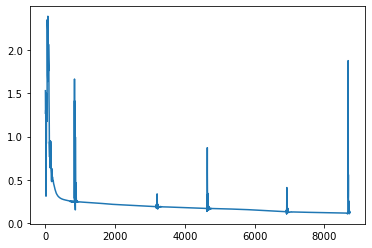

In [6]:
plt.plot([loss_history[i][1] for i in range(len(loss_history))])

In [6]:
%matplotlib qt

In [7]:
X = np.linspace(-1,1,100)
Y = np.linspace(0,1,100)
X, Y = np.meshgrid(X, Y)



x = X.reshape((-1, 1))
x = torch.tensor(x).type(torch.FloatTensor)

y = Y.reshape((-1, 1))
y = torch.tensor(y).type(torch.FloatTensor)

U = pn(x,y)

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, U.detach().numpy().reshape(100,100))
#ax.plot_wireframe(X, Y, Z, color = 'r')